In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models
import torchvision

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

c:\Users\d4\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\d4\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\d4\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.random.seed()

seed_everything(1) # Seed 고정

In [3]:
df = pd.read_csv("train.csv")
df

,sample_id,video_path,label
0,TRAIN_0000,./train/TRAIN_0000.mp4,7
1,TRAIN_0001,./train/TRAIN_0001.mp4,7
2,TRAIN_0002,./train/TRAIN_0002.mp4,0
3,TRAIN_0003,./train/TRAIN_0003.mp4,0
4,TRAIN_0004,./train/TRAIN_0004.mp4,1
...,...,...,...
2693,TRAIN_2693,./train/TRAIN_2693.mp4,3
2694,TRAIN_2694,./train/TRAIN_2694.mp4,5
2695,TRAIN_2695,./train/TRAIN_2695.mp4,0
2696,TRAIN_2696,./train/TRAIN_2696.mp4,0


In [4]:
df["A"] = df["label"] != 0
# df["label"]이 0 이 아니면 True, df["label"]이 0이면 False

In [5]:
dict = {
    True : 1,
    False : 0
}
# A = 1이면, no crash
# A = 0이면, crash

In [6]:
df["A"] = df["A"].map(dict)
df["A"]

0       1
1       1
2       0
3       0
4       1
       ..
2693    1
2694    1
2695    0
2696    0
2697    0
Name: A, Length: 2698, dtype: int64

In [7]:
df

,sample_id,video_path,label,A
0,TRAIN_0000,./train/TRAIN_0000.mp4,7,1
1,TRAIN_0001,./train/TRAIN_0001.mp4,7,1
2,TRAIN_0002,./train/TRAIN_0002.mp4,0,0
3,TRAIN_0003,./train/TRAIN_0003.mp4,0,0
4,TRAIN_0004,./train/TRAIN_0004.mp4,1,1
...,...,...,...,...
2693,TRAIN_2693,./train/TRAIN_2693.mp4,3,1
2694,TRAIN_2694,./train/TRAIN_2694.mp4,5,1
2695,TRAIN_2695,./train/TRAIN_2695.mp4,0,0
2696,TRAIN_2696,./train/TRAIN_2696.mp4,0,0


In [8]:
df["B"] = (df["label"] == 1) | (df["label"] == 2) | (df["label"] == 3) | (df["label"] == 4) | (df["label"] == 5) | (df["label"] == 6)
# ego-involve이면 1


dict1 = {
1 : 0,
2: 0,
3 : 1,
4 : 1,
5 : 2,
6 : 2,
7 : 0,
8 : 0,
9 : 1,
10 : 1,
11 : 2,
12 : 2}

dict2 = {
    1 : 0,
    2 : 1,
    3 : 0,
    4 : 1,
    5 : 0,
    6 : 1,
    7 : 0,
    8 : 1,
    9 : 0,
    10 : 1,
    11 : 0,
    12 : 1
}

dict0 = {
    1 : 1,
    2 : 1,
    3 : 1,
    4 : 1,
    5 : 1,
    6 : 1,
    7 : 0,
    8 : 0,
    9 : 0,
    10 : 0,
    11 : 0,
    12 : 0
}
df["C"] = df["label"].map(dict1)
df["D"] = (df["label"] == 1) | (df["label"] == 3) | (df["label"] == 5) | (df["label"] == 7) | (df["label"] == 9) | (df["label"] == 11) | (df["label"] == 13)
df["B"] = df["label"].map(dict0)
df["D"] = df["label"].map(dict2)

In [9]:
df

,sample_id,video_path,label,A,B,C,D
0,TRAIN_0000,./train/TRAIN_0000.mp4,7,1,0.0,0.0,0.0
1,TRAIN_0001,./train/TRAIN_0001.mp4,7,1,0.0,0.0,0.0
2,TRAIN_0002,./train/TRAIN_0002.mp4,0,0,NaN,NaN,NaN
3,TRAIN_0003,./train/TRAIN_0003.mp4,0,0,NaN,NaN,NaN
4,TRAIN_0004,./train/TRAIN_0004.mp4,1,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...
2693,TRAIN_2693,./train/TRAIN_2693.mp4,3,1,1.0,1.0,0.0
2694,TRAIN_2694,./train/TRAIN_2694.mp4,5,1,1.0,2.0,0.0
2695,TRAIN_2695,./train/TRAIN_2695.mp4,0,0,NaN,NaN,NaN
2696,TRAIN_2696,./train/TRAIN_2696.mp4,0,0,NaN,NaN,NaN


In [10]:
# A는 충돌여부
# B는 충돌했을 때 개입여부

# C는 날씨
# D는 낮과 밤

In [11]:
df["A"].value_counts()

0    1783
1     915
Name: A, dtype: int64

In [12]:
df["B"].value_counts()

1.0    490
0.0    425
Name: B, dtype: int64

In [13]:
df["C"].value_counts()

0.0    716
1.0    129
2.0     70
Name: C, dtype: int64

In [14]:
df["D"].value_counts()

0.0    808
1.0    107
Name: D, dtype: int64

In [15]:
train, val, _, _ = train_test_split(df, df[["A", "B", "C", "D"]], test_size = 0.2, random_state = 1)

In [16]:
class CustomDataset(Dataset):
    def __init__(self, video_path_list, label_list):
        self.video_path_list = video_path_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        path = self.video_path_list[index]
        frames = self.get_video(path)
        if self.label_list is not None:
            label = self.label_list[index]
            return frames, label
        else:
            return frames
        
    def __len__(self):
        return len(self.video_path_list)
    
    def get_video(self, path):
        frames = []
        cap = cv2.VideoCapture(path)
        for _ in range(50):
            _, img = cap.read()
            img = cv2.resize(img, (128, 128))
            img = img / 255.
            frames.append(img)
        return torch.FloatTensor(np.array(frames)).permute(3, 0, 1, 2)

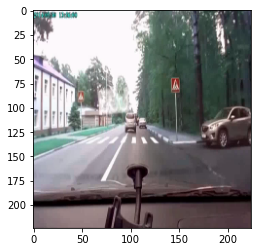

In [17]:
import matplotlib.pyplot as plt
cap = cv2.VideoCapture(train["video_path"][1])
_, img = cap.read()
img = cv2.resize(img, (224, 224))
plt.imshow(img)

In [18]:
train_dataset = CustomDataset(train['video_path'].values, train[["A", "B", "C", "D"]].values)
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val['video_path'].values, val[["A", "B", "C", "D"]].values)
val_loader = DataLoader(val_dataset, batch_size = 8, shuffle=False, num_workers=0)

In [19]:
df[["A", "B", "C", "D"]]

,A,B,C,D
0,1,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,1,1.0,0.0,0.0
...,...,...,...,...
2693,1,1.0,1.0,0.0
2694,1,1.0,2.0,0.0
2695,0,NaN,NaN,NaN
2696,0,NaN,NaN,NaN


In [20]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

In [21]:
from torchvision import transforms

In [22]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.backbone0 = models.video.r3d_18(pretrained = True)
        
        self.bn2 = nn.BatchNorm3d(6)
        self.transform = nn.Sequential( 
                                        transforms.RandomErasing(0.5),
                                        transforms.RandomHorizontalFlip(0.5),
                                        transforms.RandomCrop(size = 112)
                                        )
        self.backbone1 = models.efficientnet_b5(pretrained = True)
        self.classifier0 = nn.Linear(400, 4)
        self.classifier1 = nn.Linear(1000, 5)
    
    def forward(self, x, label = True):
        b, c, f, w, h = x.size()
        x_img = x
        batch_size = x.size(0)

        x = self.backbone0(x)
        x = x.view(b, -1)

        pred = torch.zeros((batch_size, 9))

        pred[:,:4] = self.classifier0(x)
        
        x_img = x_img.permute(2, 0, 1, 3, 4).contiguous()   
        
        if label == False : 
            for i in range(f):
                x_img[i] = self.transform(x_img[i])
            
        f, b, c, w, h = x_img.size()
        x_img = x_img[[0, 9, 19, 29, 39, 49]]
        x_img = x_img.permute(1, 0, 2, 3, 4).contiguous()
        x_img = self.bn2(x_img)
        x_img = x_img.view(b * 6, 3, 128, 128)
        x_img = self.backbone1(x_img)
        x_img = x_img.view(b * 6, -1)

        pred1 = torch.zeros((b * 6, 5))

        x_img = self.classifier1(x_img)
        pred[:, 4:] = x_img.view(b, 6, 5).mean(dim = 1)
        
        return pred

In [23]:
def map_to_f1(list):
    new_list = []
    for i in range(len(list)):
        if list[i][0] == 0:
            new_list.append(0)
        elif list[i] == [1, 1, 0, 0]:
            new_list.append(1)
        elif list[i] == [1, 1, 0, 1]:
            new_list.append(2)
        elif list[i] == [1, 1, 1, 0]:
            new_list.append(3)
        elif list[i] == [1, 1, 1, 1]:
            new_list.append(4)
        elif list[i] == [1, 1, 2, 0]:
            new_list.append(5)
        elif list[i] == [1, 1, 2, 1]:
            new_list.append(6)
        elif list[i] == [1, 0, 0, 0]:
            new_list.append(7)
        elif list[i] == [1, 0, 0, 1]:
            new_list.append(8)
        elif list[i] == [1, 0, 1, 0]:
            new_list.append(9)
        elif list[i] == [1, 0, 1, 1]:
            new_list.append(10)
        elif list[i] == [1, 0, 2, 0]:
            new_list.append(11)
        elif list[i] == [1, 0, 2, 1]:
            new_list.append(12)
        else:
            print("error")
    return new_list

In [24]:
from sklearn.utils.class_weight import compute_class_weight

class_weight_A = compute_class_weight("balanced", np.unique(df["A"]), df["A"])
class_weight_B = compute_class_weight("balanced", np.unique(df["B"].dropna()), df["B"].dropna())
class_weight_C = compute_class_weight("balanced", np.unique(df["C"].dropna()), df["C"].dropna())
class_weight_D = compute_class_weight("balanced", np.unique(df["D"].dropna()), df["D"].dropna())

In [25]:
class FocalLoss(nn.Module):
  def __init__(self, weight=None, gamma=2, reduction='mean'):
    super(FocalLoss, self).__init__()
    self.weight = weight.to(device)
    self.gamma = gamma
    self.reduction = reduction

  def forward(self, inputs, targets):
    ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction=self.reduction)
    pt = torch.exp(-ce_loss)
    focal_loss = ((1-pt)**self.gamma * ce_loss).mean()
    return focal_loss

In [26]:
def train(model, optimizer, train_loader, val_loader, scheduler, device = device):
    model = model.to(device)
    criterion0 = FocalLoss(weight = torch.tensor(class_weight_A)).to(device)
    criterion1 = FocalLoss(weight = torch.tensor(class_weight_B)).to(device)
    criterion2 = FocalLoss(weight = torch.tensor(class_weight_C)).to(device)
    criterion3 = FocalLoss(weight = torch.tensor(class_weight_D)).to(device)
    
    hist = {"train_loss" : [],
        "val_loss" : [],
        "train_score" : [],
        "val_score" : []}

    hist_ABCD = {"train_loss" : [[],[],[],[]],
                "val_loss" : [[], [], [], []]}

    best_val_score = 0
    best_model = None
    
    for epoch in range(1, 31):
        model.train()
        train_loss = []
        train_loss_ABCD = [[], [], [], []]
        preds, trues = [], []
        for videos, labels in tqdm(iter(train_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
    
            output = model(videos).to(device)
            loss = torch.zeros(4).to(device)

            for i in range(len(labels)):
                if labels[i, 0] == 0:
                    loss[0] += criterion0(output[i, :2].to(torch.float64), labels[i, 0].to(torch.long))
                else :
                    loss[0] += criterion0(output[i, :2].to(torch.float64), labels[i, 0].to(torch.long))
                    loss[1] += criterion1(output[i, 2:4].to(torch.float64), labels[i, 1].to(torch.long))
                    loss[2] += criterion2(output[i, 4:7].to(torch.float64), labels[i, 2].to(torch.long))
                    loss[3] += criterion3(output[i, 7:].to(torch.float64), labels[i, 3].to(torch.long))

            train_loss_ABCD[0].append(loss[0].item())
            train_loss_ABCD[1].append(loss[1].item())
            train_loss_ABCD[2].append(loss[2].item())
            train_loss_ABCD[3].append(loss[3].item())     
            
            loss = torch.sum(loss)
            loss.backward()
            optimizer.step()

            output = output.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()

            new_logit = np.zeros((len(labels), 4))

            new_logit[:, 0] = output[:, :2].argmax(1)
            new_logit[:, 1] = output[:, 2:4].argmax(1)
            new_logit[:, 2] = output[:, 4:7].argmax(1)
            new_logit[:, 3] = output[:, 7:].argmax(1)

            preds += new_logit.tolist()
            trues += labels.tolist()
            
            

            train_loss.append(loss.item())
            
            print("train_loss : ", np.mean(train_loss))

        
        trues = map_to_f1(trues)
        preds = map_to_f1(preds)
        train_score = f1_score(trues, preds, average = "macro")

        criterion = [criterion0, criterion1, criterion2, criterion3]
        print(f"A loss : {np.mean(train_loss_ABCD[0])}, B loss : {np.mean(train_loss_ABCD[1])}, C loss : {np.mean(train_loss_ABCD[2])}, D loss : {np.mean(train_loss_ABCD[3])}")   
        _val_loss, _val_score, val_loss_ABCD = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)

        hist_ABCD["train_loss"][0].append(np.mean(train_loss_ABCD[0]))
        hist_ABCD["train_loss"][1].append(np.mean(train_loss_ABCD[1]))
        hist_ABCD["train_loss"][2].append(np.mean(train_loss_ABCD[2]))
        hist_ABCD["train_loss"][3].append(np.mean(train_loss_ABCD[3]))

        hist_ABCD["val_loss"][0].append(np.mean(val_loss_ABCD[0]))
        hist_ABCD["val_loss"][0].append(np.mean(val_loss_ABCD[0]))
        hist_ABCD["val_loss"][0].append(np.mean(val_loss_ABCD[0]))
        hist_ABCD["val_loss"][0].append(np.mean(val_loss_ABCD[0]))
        
        hist["train_loss"].append(_train_loss)
        hist["val_loss"].append(_val_loss)
        hist["train_score"].append(train_score)
        hist["val_score"].append(_val_score)

        print(f"A loss : {np.mean(val_loss_ABCD[0])}, B loss : {np.mean(val_loss_ABCD[1])}, C loss : {np.mean(val_loss_ABCD[2])}, D loss : {np.mean(val_loss_ABCD[3])}")   
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Train F1 : [{train_score:.5f}] Val F1 : [{_val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
    
    return best_model, hist, hist_ABCD

In [27]:
def validation(model, criterion, val_loader, device = device):
    model.eval()
    val_loss = []
    val_loss_ABCD = [[],[],[],[]]
    preds, trues = [], []
    
    with torch.no_grad():
        for videos, labels in tqdm(iter(val_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            
            logit = model(videos).to(device)

            loss0 = torch.zeros(1).to(device)
            loss1 = torch.zeros(1).to(device)
            loss2 = torch.zeros(1).to(device)
            loss3 = torch.zeros(1).to(device)

            for i in range(len(labels)):
                if labels[i, 0] == 0:
                    loss0 += criterion[0](logit[i, :2].to(torch.float64), labels[i, 0].to(torch.long))
                else :
                    loss0 += criterion[0](logit[i, :2].to(torch.float64), labels[i, 0].to(torch.long))
                    loss1 += criterion[1](logit[i, 2:4].to(torch.float64), labels[i, 1].to(torch.long))
                    loss2 += criterion[2](logit[i, 4:7].to(torch.float64), labels[i, 2].to(torch.long))
                    loss3 += criterion[3](logit[i, 7:].to(torch.float64), labels[i, 3].to(torch.long))

            loss = loss0 + loss1 + loss2 + loss3
            print(f"A loss : {loss0.item()}, B loss : {loss1.item()}, C loss : {loss2.item()}, D loss : {loss3.item()}") 
            print("valid loss : ", loss.item())
                
            logit = logit.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()

            new_logit = np.zeros((len(labels), 4))

            new_logit[:, 0] = logit[:, :2].argmax(1)
            new_logit[:, 1] = logit[:, 2:4].argmax(1)
            new_logit[:, 2] = logit[:, 4:7].argmax(1)
            new_logit[:, 3] = logit[:, 7:].argmax(1)

            preds += new_logit.tolist()
            trues += labels.tolist()

            val_loss.append(loss.item())
            val_loss_ABCD[0].append(loss0.item())
            val_loss_ABCD[1].append(loss1.item())
            val_loss_ABCD[2].append(loss2.item())
            val_loss_ABCD[3].append(loss3.item())
            
        _val_loss = np.mean(val_loss)
    trues = map_to_f1(trues)
    preds = map_to_f1(preds)
    _val_score = f1_score(trues, preds, average='macro')
    return _val_loss, _val_score, val_loss_ABCD

In [28]:
device

device(type='cuda')

In [29]:
model = Model()

model.eval()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = 5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2,threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model, hist, hist_ABCD = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  7.7199578285217285
train_loss :  193.45275235176086
train_loss :  1258.5887815157573
train_loss :  1309.0244718790054
train_loss :  1625.4322239875794
train_loss :  1736.6995828151703
train_loss :  1663.8787997790746
train_loss :  1560.1083815693855
train_loss :  1449.9736042552524
train_loss :  1844.8627672672271
train_loss :  1771.5905971960588
train_loss :  1848.0117176771164
train_loss :  1726.4006126477168
train_loss :  2064.984162637166
train_loss :  2212.9639293988544
train_loss :  2075.114496976137
train_loss :  1978.389119568993
train_loss :  1878.3444067902035
train_loss :  1843.5209629912126
train_loss :  1752.4264645814897
train_loss :  1714.4403538703918
train_loss :  1695.2412883801894
train_loss :  1679.8097823806431
train_loss :  1693.7719368338585
train_loss :  1713.8730124855042
train_loss :  1715.3696709596193
train_loss :  1708.2742917979206
train_loss :  1703.0587941067558
train_loss :  1738.846342760941
train_loss :  1717.779015938441
train_loss :  1

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 1.1616432666778564, B loss : 0.13745753467082977, C loss : 4.51888370513916, D loss : 5.90774393081665
valid loss :  11.725728988647461
A loss : 0.866641640663147, B loss : 0.5639036893844604, C loss : 6.090049743652344, D loss : 17.545387268066406
valid loss :  25.065982818603516
A loss : 1.08965003490448, B loss : 0.5293649435043335, C loss : 5.5108712331275456e-06, D loss : 17.75286102294922
valid loss :  19.37188148498535
A loss : 1.0274724960327148, B loss : 0.28424298763275146, C loss : 3.27667839883361e-06, D loss : 11.906840324401855
valid loss :  13.218559265136719
A loss : 1.303025245666504, B loss : 0.5751336812973022, C loss : 12.190523147583008, D loss : 17.607221603393555
valid loss :  31.6759033203125
A loss : 1.02554190158844, B loss : 0.6890148520469666, C loss : 6.123319625854492, D loss : 23.72423553466797
valid loss :  31.562110900878906
A loss : 1.1233532428741455, B loss : 1.0213048458099365, C loss : 16.650279998779297, D loss : 23.447349548339844
valid 

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  40.2489128112793
train_loss :  23.278513431549072
train_loss :  17.169613520304363
train_loss :  13.78406023979187
train_loss :  13.344232749938964
train_loss :  11.393501420815786
train_loss :  9.992104513304573
train_loss :  8.898149818181992
train_loss :  8.50750305917528
train_loss :  7.801293206214905
train_loss :  7.248207038099116
train_loss :  6.738085975249608
train_loss :  8.836015765483562
train_loss :  8.278002670833043
train_loss :  7.895816707611084
train_loss :  7.5285391211509705
train_loss :  7.193499053225798
train_loss :  7.353044185373518
train_loss :  7.430099380643744
train_loss :  7.153267097473145
train_loss :  6.890390458561125
train_loss :  7.582473641092127
train_loss :  7.486081636470297
train_loss :  7.203819630046685
train_loss :  7.036796987056732
train_loss :  6.953106217659437
train_loss :  7.191315118913297
train_loss :  7.039808611784663
train_loss :  6.882689358859227
train_loss :  6.687987997134527
train_loss :  6.662737525278522
train

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.8074339628219604, B loss : 0.1651376634836197, C loss : 5.117369174957275, D loss : 8.509204864501953
valid loss :  14.599145889282227
A loss : 0.8388768434524536, B loss : 0.5153761506080627, C loss : 0.517061173915863, D loss : 25.526363372802734
valid loss :  27.39767837524414
A loss : 1.2090007066726685, B loss : 0.5227606296539307, C loss : 0.21647429466247559, D loss : 25.52832794189453
valid loss :  27.476564407348633
A loss : 1.0002107620239258, B loss : 0.3323327302932739, C loss : 0.1442350447177887, D loss : 17.01974105834961
valid loss :  18.496519088745117
A loss : 1.334457516670227, B loss : 0.5291174650192261, C loss : 0.8180813789367676, D loss : 25.526988983154297
valid loss :  28.20864486694336
A loss : 1.4071630239486694, B loss : 0.6877389550209045, C loss : 0.5897812843322754, D loss : 34.03759765625
valid loss :  36.72228240966797
A loss : 1.5014766454696655, B loss : 0.8780524134635925, C loss : 6.006910800933838, D loss : 34.035404205322266
valid loss

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  1.5688765048980713
train_loss :  1.7247726321220398
train_loss :  2.4126286109288535
train_loss :  2.0673087537288666
train_loss :  2.574612784385681
train_loss :  3.0402132471402488
train_loss :  2.9158814464296614
train_loss :  2.709420293569565
train_loss :  3.0169658395979138
train_loss :  2.968914532661438
train_loss :  3.142979210073298
train_loss :  3.1364460984865823
train_loss :  3.2094152707319994
train_loss :  3.1366629770823886
train_loss :  3.163057724634806
train_loss :  3.237224891781807
train_loss :  3.0853117599206814
train_loss :  3.155572477314207
train_loss :  3.279164173101124
train_loss :  3.31544106900692
train_loss :  3.364974325611478
train_loss :  3.3302807347341017
train_loss :  3.298316610896069
train_loss :  3.194393369058768
train_loss :  3.1331328415870665
train_loss :  3.033972600331673
train_loss :  2.982880179528837
train_loss :  2.9023037531546185
train_loss :  3.2781151307040246
train_loss :  3.2259365538756053
train_loss :  3.200453317

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.8003233671188354, B loss : 0.1328534185886383, C loss : 22.06258201599121, D loss : 4.7842894197128866e-15
valid loss :  22.995758056640625
A loss : 0.7458472847938538, B loss : 0.4751983880996704, C loss : 0.7075597643852234, D loss : 1.4318339808076785e-14
valid loss :  1.928605556488037
A loss : 1.1103345155715942, B loss : 0.5576406717300415, C loss : 0.0789535790681839, D loss : 1.4361372469929093e-14
valid loss :  1.7469288110733032
A loss : 0.9461273550987244, B loss : 0.2700468599796295, C loss : 0.05269497632980347, D loss : 9.586095480774992e-15
valid loss :  1.268869161605835
A loss : 1.3609693050384521, B loss : 0.5828084945678711, C loss : 1.3324716091156006, D loss : 1.433807567574781e-14
valid loss :  3.276249408721924
A loss : 1.2954524755477905, B loss : 0.6504948139190674, C loss : 0.7303866147994995, D loss : 1.9154189817354936e-14
valid loss :  2.6763339042663574
A loss : 1.3538904190063477, B loss : 0.9308139085769653, C loss : 23.421850204467773, D loss

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  29.497989654541016
train_loss :  59.12717247009277
train_loss :  42.52760537465414
train_loss :  32.72252368927002
train_loss :  28.914271736145018
train_loss :  32.20593150456747
train_loss :  38.17421627044678
train_loss :  38.47255527973175
train_loss :  34.33038557900323
train_loss :  34.597733449935916
train_loss :  31.584003296765413
train_loss :  29.834127525488537
train_loss :  29.628804812064537
train_loss :  28.301009127071925
train_loss :  27.31994153658549
train_loss :  25.683984026312828
train_loss :  25.79534394600812
train_loss :  26.078210287623936
train_loss :  24.848198388752184
train_loss :  25.422342538833618
train_loss :  24.314897242046538
train_loss :  23.240709974007174
train_loss :  22.26706720435101
train_loss :  21.401188204685848
train_loss :  20.58542823314667
train_loss :  20.107866172607128
train_loss :  19.398362495281077
train_loss :  18.748739855630056
train_loss :  18.190912090498827
train_loss :  18.241681329409282
train_loss :  18.1213

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.8268893361091614, B loss : 0.13003315031528473, C loss : 21.669620513916016, D loss : 11.360199928283691
valid loss :  33.98674392700195
A loss : 0.730272114276886, B loss : 0.49443936347961426, C loss : 7.209390640258789, D loss : 34.069000244140625
valid loss :  42.50310134887695
A loss : 1.024308204650879, B loss : 0.5505251288414001, C loss : 1.1642712349768658e-09, D loss : 34.08739471435547
valid loss :  35.662227630615234
A loss : 0.9070011377334595, B loss : 0.26953554153442383, C loss : 7.747655850209867e-10, D loss : 22.728092193603516
valid loss :  23.90462875366211
A loss : 1.2109774351119995, B loss : 0.5693885684013367, C loss : 14.424814224243164, D loss : 34.0792236328125
valid loss :  50.28440475463867
A loss : 1.1484367847442627, B loss : 0.7095870971679688, C loss : 7.2152557373046875, D loss : 45.45269012451172
valid loss :  54.525970458984375
A loss : 1.209537386894226, B loss : 1.059444546699524, C loss : 36.09231185913086, D loss : 45.43113327026367
va

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  2.0020718574523926
train_loss :  14.036641359329224
train_loss :  10.845181941986084
train_loss :  8.513183861970901
train_loss :  7.204056620597839
train_loss :  6.398679355780284
train_loss :  5.784164002963474
train_loss :  5.235533952713013
train_loss :  4.897654162512885
train_loss :  4.940388250350952
train_loss :  4.58985815264962
train_loss :  4.359645903110504
train_loss :  4.1657969401432915
train_loss :  4.182694026402065
train_loss :  4.406546783447266
train_loss :  4.192936282604933
train_loss :  4.001892198534573
train_loss :  3.8641456398699017
train_loss :  3.852779655080093
train_loss :  4.532225003838539
train_loss :  4.51688677072525
train_loss :  4.402288575064052
train_loss :  4.500960606595744
train_loss :  4.5084913447499275
train_loss :  4.417761504650116
train_loss :  4.379110783338547
train_loss :  4.276612442952615
train_loss :  4.617469977055277
train_loss :  4.518303852656792
train_loss :  4.477741191784541
train_loss :  4.81265180149386
train

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.6916295289993286, B loss : 0.13679730892181396, C loss : 9.942900657653809, D loss : 4.5896100997924805
valid loss :  15.36093807220459
A loss : 0.6271550059318542, B loss : 0.4878336787223816, C loss : 2.728649377822876, D loss : 13.749488830566406
valid loss :  17.59312629699707
A loss : 0.9855102300643921, B loss : 0.5699039697647095, C loss : 0.00036012561758980155, D loss : 13.775697708129883
valid loss :  15.331472396850586
A loss : 0.8186929225921631, B loss : 0.27312469482421875, C loss : 0.00023981646518222988, D loss : 9.188243865966797
valid loss :  10.280301094055176
A loss : 1.4327611923217773, B loss : 0.5643441677093506, C loss : 5.460702896118164, D loss : 13.76362419128418
valid loss :  21.221431732177734
A loss : 1.1404486894607544, B loss : 0.6312336921691895, C loss : 2.7326536178588867, D loss : 18.37225914001465
valid loss :  22.87659454345703
A loss : 1.2333600521087646, B loss : 0.8463571667671204, C loss : 15.400131225585938, D loss : 18.343666076660

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  4.300051212310791
train_loss :  2.764507532119751
train_loss :  2.1150998075803122
train_loss :  1.9219077974557877
train_loss :  2.8027798771858214
train_loss :  2.5710697074731192
train_loss :  2.511289349624089
train_loss :  2.725396655499935
train_loss :  2.8382577300071716
train_loss :  2.7240895688533784
train_loss :  2.6755196777257053
train_loss :  2.9035176783800125
train_loss :  2.8344973554978004
train_loss :  2.743563400847571
train_loss :  2.6607356905937194
train_loss :  2.911689568310976
train_loss :  2.891643092912786
train_loss :  2.8030747738149433
train_loss :  3.219582397686808
train_loss :  3.2285112768411635
train_loss :  3.2026217920439586
train_loss :  3.2274196608500048
train_loss :  3.384208163489466
train_loss :  3.319129245976607
train_loss :  3.348699128627777
train_loss :  3.3437783144987545
train_loss :  3.371260110978727
train_loss :  3.34247273845332
train_loss :  3.282950382808159
train_loss :  3.2433511157830557
train_loss :  3.247524213

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.5816993713378906, B loss : 0.17035070061683655, C loss : 8.694172859191895, D loss : 3.913494110107422
valid loss :  13.35971736907959
A loss : 0.5528451204299927, B loss : 0.5650153160095215, C loss : 4.19259786605835, D loss : 11.721290588378906
valid loss :  17.031749725341797
A loss : 1.0670182704925537, B loss : 0.5314620733261108, C loss : 7.4839035733020864e-06, D loss : 11.745119094848633
valid loss :  13.343606948852539
A loss : 0.7796158790588379, B loss : 0.3328792452812195, C loss : 4.972459009877639e-06, D loss : 7.833885192871094
valid loss :  8.946385383605957
A loss : 1.2281328439712524, B loss : 0.4589118957519531, C loss : 8.398332595825195, D loss : 11.734972953796387
valid loss :  21.820350646972656
A loss : 1.398379921913147, B loss : 0.7850309610366821, C loss : 4.204004287719727, D loss : 15.662118911743164
valid loss :  22.04953384399414
A loss : 1.336014747619629, B loss : 1.0686957836151123, C loss : 17.08762550354004, D loss : 15.635751724243164
va

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  1.1280462741851807
train_loss :  2.785906195640564
train_loss :  4.3385177453358965
train_loss :  3.5530073642730713
train_loss :  4.675828742980957
train_loss :  4.148864030838013
train_loss :  3.9979861804417203
train_loss :  3.9799860417842865
train_loss :  3.7150836520724826
train_loss :  3.5261620044708253
train_loss :  3.28832165219567
train_loss :  3.10239348312219
train_loss :  2.925343618943141
train_loss :  2.8627452296870097
train_loss :  3.365458246072133
train_loss :  3.242738652974367
train_loss :  3.1519466042518616
train_loss :  3.101687832011117
train_loss :  3.086297239127912
train_loss :  3.14727568924427
train_loss :  3.0261018191065108
train_loss :  2.9888013303279877
train_loss :  3.1118289724640222
train_loss :  3.095912309984366
train_loss :  3.0768914914131162
train_loss :  3.0786951894943533
train_loss :  2.997575726774004
train_loss :  2.9490725291626796
train_loss :  2.9196774199091156
train_loss :  2.9421274165312448
train_loss :  2.9409608437

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.5857939124107361, B loss : 0.13931168615818024, C loss : 0.9747220277786255, D loss : 0.1502854824066162
valid loss :  1.8501131534576416
A loss : 0.6247499585151672, B loss : 0.49107348918914795, C loss : 1.2894264459609985, D loss : 0.42544981837272644
valid loss :  2.830699920654297
A loss : 1.3529741764068604, B loss : 0.5811898708343506, C loss : 0.22737470269203186, D loss : 0.477226197719574
valid loss :  2.6387650966644287
A loss : 0.8365329504013062, B loss : 0.28105056285858154, C loss : 0.15252947807312012, D loss : 0.32881003618240356
valid loss :  1.5989229679107666
A loss : 0.7157405018806458, B loss : 0.5187277793884277, C loss : 2.38161039352417, D loss : 0.4467718005180359
valid loss :  4.062850475311279
A loss : 1.143442988395691, B loss : 0.6726179718971252, C loss : 1.4027782678604126, D loss : 0.6499552130699158
valid loss :  3.8687944412231445
A loss : 1.4021339416503906, B loss : 0.9228730201721191, C loss : 3.4449424743652344, D loss : 0.7501449584960

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  3.0676991939544678
train_loss :  3.9158302545547485
train_loss :  3.3218024571736655
train_loss :  2.7839529514312744
train_loss :  3.0444618225097657
train_loss :  3.0828018188476562
train_loss :  2.856998920440674
train_loss :  2.731313645839691
train_loss :  2.696278625064426
train_loss :  2.67618727684021
train_loss :  2.5763657960024746
train_loss :  2.517350415388743
train_loss :  2.39237373150312
train_loss :  2.2779605856963565
train_loss :  2.3485279202461244
train_loss :  2.4462032727897167
train_loss :  2.4156750826274647
train_loss :  2.4047756758001118
train_loss :  2.3248712263609232
train_loss :  2.274325466156006
train_loss :  2.2373024622599282
train_loss :  2.2557917724956167
train_loss :  2.3777580053909966
train_loss :  2.354036142428716
train_loss :  2.2925254821777346
train_loss :  2.233843821745652
train_loss :  2.270931349860297
train_loss :  2.3106758253914967
train_loss :  2.2918972393562056
train_loss :  2.249644152323405
train_loss :  2.2015898

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.5481127500534058, B loss : 0.14936065673828125, C loss : 1.7615208625793457, D loss : 0.03517277538776398
valid loss :  2.4941670894622803
A loss : 0.5380523800849915, B loss : 0.49566248059272766, C loss : 0.7756655216217041, D loss : 0.09445290267467499
valid loss :  1.903833270072937
A loss : 1.3085044622421265, B loss : 0.5664247870445251, C loss : 0.2618730664253235, D loss : 0.12244298309087753
valid loss :  2.2592451572418213
A loss : 0.8190267086029053, B loss : 0.2979314923286438, C loss : 0.17623096704483032, D loss : 0.08812383562326431
valid loss :  1.3813128471374512
A loss : 0.8412232995033264, B loss : 0.5252258777618408, C loss : 1.2744266986846924, D loss : 0.1059790700674057
valid loss :  2.746854782104492
A loss : 0.8355814218521118, B loss : 0.6667426824569702, C loss : 0.8400905728340149, D loss : 0.17377199232578278
valid loss :  2.5161867141723633
A loss : 1.225856900215149, B loss : 0.8882243633270264, C loss : 3.1231441497802734, D loss : 0.565109670

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  1.041115403175354
train_loss :  2.1864293217658997
train_loss :  2.247611323992411
train_loss :  1.8793388307094574
train_loss :  2.044330048561096
train_loss :  2.07567431529363
train_loss :  2.3879107918058122
train_loss :  2.266528159379959
train_loss :  2.5025122695498996
train_loss :  2.4515973567962646
train_loss :  2.426567706194791
train_loss :  2.373621344566345
train_loss :  2.472140018756573
train_loss :  2.430679508617946
train_loss :  2.512502829233805
train_loss :  2.4558444917201996
train_loss :  2.444229434518253
train_loss :  2.4833301173316107
train_loss :  2.6135794990941097
train_loss :  2.5366515040397646
train_loss :  2.5417247272673107
train_loss :  2.5283125313845547
train_loss :  2.460922604021819
train_loss :  2.461947272221247
train_loss :  2.493601083755493
train_loss :  2.580573788056007
train_loss :  2.6116468376583524
train_loss :  2.697905719280243
train_loss :  2.7744379454645616
train_loss :  2.7113511482874553
train_loss :  2.81838870048

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.49345627427101135, B loss : 0.15134112536907196, C loss : 1.283746361732483, D loss : 0.04030735790729523
valid loss :  1.9688512086868286
A loss : 0.4598064720630646, B loss : 0.5018264651298523, C loss : 0.937731921672821, D loss : 0.10172121226787567
valid loss :  2.0010862350463867
A loss : 1.2939600944519043, B loss : 0.5769754648208618, C loss : 0.30085113644599915, D loss : 0.15217100083827972
valid loss :  2.323957681655884
A loss : 0.7728652358055115, B loss : 0.3022029995918274, C loss : 0.20419374108314514, D loss : 0.11245997250080109
valid loss :  1.3917219638824463
A loss : 0.8722653985023499, B loss : 0.5049113035202026, C loss : 1.5581247806549072, D loss : 0.1212465912103653
valid loss :  3.0565481185913086
A loss : 0.962281346321106, B loss : 0.6884661316871643, C loss : 1.0083231925964355, D loss : 0.22061589360237122
valid loss :  2.8796865940093994
A loss : 1.2949894666671753, B loss : 0.9311537146568298, C loss : 2.9525887966156006, D loss : 0.478708118

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  1.8046092987060547
train_loss :  2.608365535736084
train_loss :  2.2372829914093018
train_loss :  2.2688860297203064
train_loss :  2.5056498527526854
train_loss :  2.545892119407654
train_loss :  2.531306675502232
train_loss :  2.40731680393219
train_loss :  2.496121433046129
train_loss :  2.4500306844711304
train_loss :  2.3993253382769497
train_loss :  2.420143852631251
train_loss :  2.36081024316641
train_loss :  2.304381217275347
train_loss :  2.3396095434824624
train_loss :  2.396201267838478
train_loss :  2.500847073162303
train_loss :  2.512355910407172
train_loss :  2.461927664907355
train_loss :  2.4580976247787474
train_loss :  2.4865305650801885
train_loss :  2.5000071850689976
train_loss :  2.5435602975928266
train_loss :  2.5636207660039267
train_loss :  2.5045945978164674
train_loss :  2.4877362755628734
train_loss :  2.633181761812281
train_loss :  2.5743254657302583
train_loss :  2.5892428015840463
train_loss :  2.5609101752440133
train_loss :  2.553464433

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.46903446316719055, B loss : 0.13595479726791382, C loss : 0.901779294013977, D loss : 0.11153977364301682
valid loss :  1.6183083057403564
A loss : 0.5885766744613647, B loss : 0.4899832010269165, C loss : 1.0625094175338745, D loss : 0.2370065599679947
valid loss :  2.3780760765075684
A loss : 1.351696252822876, B loss : 0.5795203447341919, C loss : 0.47688359022140503, D loss : 0.46372872591018677
valid loss :  2.87182879447937
A loss : 0.7676472067832947, B loss : 0.27165043354034424, C loss : 0.3230823576450348, D loss : 0.3522144556045532
valid loss :  1.7145943641662598
A loss : 1.7053718566894531, B loss : 0.5727355480194092, C loss : 1.6222279071807861, D loss : 0.3288136422634125
valid loss :  4.229148864746094
A loss : 0.6403229832649231, B loss : 0.623842179775238, C loss : 1.1844617128372192, D loss : 0.6904628276824951
valid loss :  3.139089822769165
A loss : 0.9192719459533691, B loss : 0.8386574387550354, C loss : 2.7000608444213867, D loss : 0.460426986217498

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  1.6778769493103027
train_loss :  1.9367785453796387
train_loss :  1.805172363917033
train_loss :  2.0299928188323975
train_loss :  2.275481605529785
train_loss :  2.336761474609375
train_loss :  2.4993846075875417
train_loss :  2.560644567012787
train_loss :  2.722812705569797
train_loss :  2.7359899520874023
train_loss :  2.7078163623809814
train_loss :  2.6031151016553244
train_loss :  2.693273030794584
train_loss :  2.7800172907965526
train_loss :  2.7143113454182943
train_loss :  2.6066817827522755
train_loss :  2.5158259623190937
train_loss :  2.468854457139969
train_loss :  2.459094038135127
train_loss :  2.3948498994112013
train_loss :  2.551773142246973
train_loss :  2.5512436547062616
train_loss :  2.6546450723772463
train_loss :  2.7317269071936607
train_loss :  2.6461286425590513
train_loss :  2.6141755420428057
train_loss :  2.5694594228709184
train_loss :  2.530525409749576
train_loss :  2.4725020219539773
train_loss :  2.430465114116669
train_loss :  2.39812

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.5131204724311829, B loss : 0.15057320892810822, C loss : 0.9872420430183411, D loss : 0.05531734228134155
valid loss :  1.7062530517578125
A loss : 0.478262722492218, B loss : 0.4992322623729706, C loss : 0.9730372428894043, D loss : 0.11779594421386719
valid loss :  2.0683281421661377
A loss : 1.0133039951324463, B loss : 0.5530393719673157, C loss : 0.673740029335022, D loss : 0.2566341161727905
valid loss :  2.4967174530029297
A loss : 0.7498156428337097, B loss : 0.30137231945991516, C loss : 0.4702634811401367, D loss : 0.19472679495811462
valid loss :  1.716178297996521
A loss : 0.7322383522987366, B loss : 0.5405141115188599, C loss : 1.2240464687347412, D loss : 0.1746520698070526
valid loss :  2.6714510917663574
A loss : 0.7265112400054932, B loss : 0.655289888381958, C loss : 1.1110429763793945, D loss : 0.37832486629486084
valid loss :  2.871169090270996
A loss : 1.175105094909668, B loss : 0.8599981069564819, C loss : 2.4870712757110596, D loss : 0.34472870826721

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  2.1086435317993164
train_loss :  2.4407851696014404
train_loss :  2.390885909398397
train_loss :  2.297447979450226
train_loss :  2.5136507511138917
train_loss :  2.23462841908137
train_loss :  2.151711651257106
train_loss :  2.190117284655571
train_loss :  2.068177196714613
train_loss :  2.088979983329773
train_loss :  2.171702601692893
train_loss :  2.132628639539083
train_loss :  2.2202726877652683
train_loss :  2.2318118129457747
train_loss :  2.193410849571228
train_loss :  2.123743124306202
train_loss :  2.1013858318328857
train_loss :  2.0561463236808777
train_loss :  2.176409539423491
train_loss :  2.1790860831737517
train_loss :  2.17057090146201
train_loss :  2.126183981245214
train_loss :  2.1440443629803867
train_loss :  2.2332663784424462
train_loss :  2.3834029245376587
train_loss :  2.399500521329733
train_loss :  2.3475038652066833
train_loss :  2.2914818844624927
train_loss :  2.2482434285098107
train_loss :  2.306760118405024
train_loss :  2.322288188242

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.471304327249527, B loss : 0.1676207333803177, C loss : 1.1468485593795776, D loss : 0.04037558287382126
valid loss :  1.8261492252349854
A loss : 0.45397448539733887, B loss : 0.5872175693511963, C loss : 1.0647305250167847, D loss : 0.0987292006611824
valid loss :  2.2046518325805664
A loss : 0.9302061200141907, B loss : 0.4898175597190857, C loss : 0.24691495299339294, D loss : 0.13600091636180878
valid loss :  1.802939534187317
A loss : 0.7872300744056702, B loss : 0.33316895365715027, C loss : 0.16283264756202698, D loss : 0.09827214479446411
valid loss :  1.3815038204193115
A loss : 1.2152520418167114, B loss : 0.48379045724868774, C loss : 1.9077785015106201, D loss : 0.11207982897758484
valid loss :  3.7189009189605713
A loss : 0.6140551567077637, B loss : 0.7172155976295471, C loss : 1.193395733833313, D loss : 0.18961618840694427
valid loss :  2.714282512664795
A loss : 1.1006548404693604, B loss : 1.244947910308838, C loss : 3.1564626693725586, D loss : 0.464432835

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  2.940643787384033
train_loss :  2.854921817779541
train_loss :  2.6002809206644693
train_loss :  2.5911293625831604
train_loss :  2.5596962451934813
train_loss :  2.4642656644185386
train_loss :  2.38768584387643
train_loss :  2.1759097799658775
train_loss :  2.1012020309766135
train_loss :  2.0099786937236788
train_loss :  2.015387573025443
train_loss :  2.1487968116998672
train_loss :  2.0795193039453945
train_loss :  2.037927827664784
train_loss :  2.004643404483795
train_loss :  1.9264460541307926
train_loss :  1.8653755012680502
train_loss :  1.900501115454568
train_loss :  1.868125241053732
train_loss :  1.8723263949155808
train_loss :  1.946960741565341
train_loss :  2.0324175330725582
train_loss :  1.9779191146726194
train_loss :  2.0512181545297303
train_loss :  2.0684352707862854
train_loss :  2.204331161884161
train_loss :  2.2563113305303784
train_loss :  2.2446191757917404
train_loss :  2.1947394033958174
train_loss :  2.2188204566637677
train_loss :  2.18051

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.5921191573143005, B loss : 0.1478215456008911, C loss : 1.2456955909729004, D loss : 0.12167714536190033
valid loss :  2.107313394546509
A loss : 0.5837141871452332, B loss : 0.4993804097175598, C loss : 0.8851541876792908, D loss : 0.1960166096687317
valid loss :  2.1642653942108154
A loss : 0.9704041481018066, B loss : 0.5576238036155701, C loss : 0.5066159963607788, D loss : 0.4741881489753723
valid loss :  2.5088322162628174
A loss : 0.9227721691131592, B loss : 0.2972906231880188, C loss : 0.35686373710632324, D loss : 0.40355169773101807
valid loss :  1.9804781675338745
A loss : 0.592553973197937, B loss : 0.5374102592468262, C loss : 1.182051420211792, D loss : 0.2899165153503418
valid loss :  2.6019320487976074
A loss : 0.9727941751480103, B loss : 0.6420377492904663, C loss : 0.9485241770744324, D loss : 0.7063800096511841
valid loss :  3.2697362899780273
A loss : 1.671679139137268, B loss : 0.8708897829055786, C loss : 2.7169835567474365, D loss : 0.401122093200683

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  3.5591840744018555
train_loss :  3.1462037563323975
train_loss :  2.645796298980713
train_loss :  2.1750356256961823
train_loss :  2.3927260637283325
train_loss :  2.4234943985939026
train_loss :  2.453912002699716
train_loss :  2.839635208249092
train_loss :  2.9483077923456826
train_loss :  2.888476026058197
train_loss :  2.7650949954986572
train_loss :  2.637998561064402
train_loss :  2.5407190964772153
train_loss :  2.4978354573249817
train_loss :  2.3959151029586794
train_loss :  2.3059733510017395
train_loss :  2.327340518727022
train_loss :  2.2522167464097342
train_loss :  2.1881522724502966
train_loss :  2.1728109806776046
train_loss :  2.1919492284456887
train_loss :  2.1721850660714237
train_loss :  2.146092396715413
train_loss :  2.143749438226223
train_loss :  2.140772936344147
train_loss :  2.1404463167373953
train_loss :  2.16380927518562
train_loss :  2.2142693336520876
train_loss :  2.23077280973566
train_loss :  2.2413316905498504
train_loss :  2.2731012

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.5367667078971863, B loss : 0.1370440125465393, C loss : 1.581750512123108, D loss : 0.014681405387818813
valid loss :  2.270242691040039
A loss : 0.49837806820869446, B loss : 0.48890772461891174, C loss : 1.0366935729980469, D loss : 0.02810249850153923
valid loss :  2.052081823348999
A loss : 0.6838538646697998, B loss : 0.5689361691474915, C loss : 0.15450073778629303, D loss : 0.042671751230955124
valid loss :  1.4499624967575073
A loss : 0.7548666596412659, B loss : 0.2751840353012085, C loss : 0.10420146584510803, D loss : 0.04204574227333069
valid loss :  1.176297903060913
A loss : 0.5622597336769104, B loss : 0.5598760843276978, C loss : 1.904392123222351, D loss : 0.02692636474967003
valid loss :  3.0534541606903076
A loss : 0.802534818649292, B loss : 0.6263997554779053, C loss : 1.0566143989562988, D loss : 0.056651435792446136
valid loss :  2.5422003269195557
A loss : 1.28823983669281, B loss : 0.8543491363525391, C loss : 3.4917078018188477, D loss : 0.416206121

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  1.6751652956008911
train_loss :  2.058160960674286
train_loss :  2.24077045917511
train_loss :  1.8785958886146545
train_loss :  1.656906044483185
train_loss :  1.7347712616125743
train_loss :  1.9777606640543257
train_loss :  1.8245131149888039
train_loss :  1.8371975355678134
train_loss :  1.9878868758678436
train_loss :  1.9003397280519658
train_loss :  2.3147157778342566
train_loss :  2.2400835614938
train_loss :  2.1397529201848164
train_loss :  2.0757743239402773
train_loss :  2.083910498768091
train_loss :  2.1942018515923443
train_loss :  2.130690339538786
train_loss :  2.1057798642861214
train_loss :  2.0504520356655123
train_loss :  2.1090418213889714
train_loss :  2.1144451824101536
train_loss :  2.0674482428509258
train_loss :  2.058606823285421
train_loss :  2.04386004447937
train_loss :  2.1882822788678684
train_loss :  2.1767326637550637
train_loss :  2.1928207533700124
train_loss :  2.251035032601192
train_loss :  2.3185922622680666
train_loss :  2.2884073

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.5369085073471069, B loss : 0.14835987985134125, C loss : 0.8775056600570679, D loss : 0.04659322276711464
valid loss :  1.6093672513961792
A loss : 0.6617443561553955, B loss : 0.49533790349960327, C loss : 1.0362201929092407, D loss : 0.09115470200777054
valid loss :  2.2844574451446533
A loss : 0.66756671667099, B loss : 0.5705511569976807, C loss : 0.45725956559181213, D loss : 0.14612045884132385
valid loss :  1.8414978981018066
A loss : 0.9440335631370544, B loss : 0.2975550889968872, C loss : 0.31722354888916016, D loss : 0.13756230473518372
valid loss :  1.6963744163513184
A loss : 0.5778816938400269, B loss : 0.560346782207489, C loss : 1.6572182178497314, D loss : 0.09996867179870605
valid loss :  2.8954153060913086
A loss : 0.7627991437911987, B loss : 0.6459408402442932, C loss : 1.2304195165634155, D loss : 0.19990217685699463
valid loss :  2.839061737060547
A loss : 1.876376986503601, B loss : 0.8091219067573547, C loss : 2.8463656902313232, D loss : 0.248077064

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  2.3130435943603516
train_loss :  2.3372427225112915
train_loss :  2.4528887271881104
train_loss :  2.409127175807953
train_loss :  2.2188340425491333
train_loss :  2.5111761689186096
train_loss :  2.5370525462286815
train_loss :  2.5097194761037827
train_loss :  2.447709070311652
train_loss :  2.3663188099861143
train_loss :  2.370247396555814
train_loss :  2.541816701491674
train_loss :  2.418531055633838
train_loss :  2.4587897615773335
train_loss :  2.3974127968152366
train_loss :  2.4640273936092854
train_loss :  2.418695768889259
train_loss :  2.34432562523418
train_loss :  2.409962092575274
train_loss :  2.400861182808876
train_loss :  2.3206994221324013
train_loss :  2.276580748232928
train_loss :  2.219931400340536
train_loss :  2.2193683038155236
train_loss :  2.191982750892639
train_loss :  2.3077232516728916
train_loss :  2.3611258533265858
train_loss :  2.324635718550001
train_loss :  2.340953021213926
train_loss :  2.3191317121187844
train_loss :  2.275956809

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.3536040186882019, B loss : 0.14747749269008636, C loss : 1.2708662748336792, D loss : 0.028596928343176842
valid loss :  1.8005447387695312
A loss : 0.3737306594848633, B loss : 0.4989679455757141, C loss : 0.8927283883094788, D loss : 0.04852600023150444
valid loss :  1.8139530420303345
A loss : 0.6096269488334656, B loss : 0.5505089163780212, C loss : 0.3206402063369751, D loss : 0.09538665413856506
valid loss :  1.5761626958847046
A loss : 0.552078127861023, B loss : 0.30120131373405457, C loss : 0.21876266598701477, D loss : 0.11682895570993423
valid loss :  1.1888710260391235
A loss : 0.6932021379470825, B loss : 0.5437365174293518, C loss : 1.4838088750839233, D loss : 0.0631294921040535
valid loss :  2.783876895904541
A loss : 0.5008302927017212, B loss : 0.6485440135002136, C loss : 1.020799994468689, D loss : 0.14243708550930023
valid loss :  2.3126111030578613
A loss : 1.2797330617904663, B loss : 0.8905824422836304, C loss : 2.9622244834899902, D loss : 0.15009954

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  3.373487710952759
train_loss :  2.76685106754303
train_loss :  2.2339237133661904
train_loss :  3.175592988729477
train_loss :  2.775285005569458
train_loss :  2.447327454884847
train_loss :  2.2984990222113475
train_loss :  2.1217212826013565
train_loss :  2.0749616622924805
train_loss :  1.994577133655548
train_loss :  1.9389080676165493
train_loss :  1.8854962189992268
train_loss :  1.8402278331609874
train_loss :  1.8252124530928475
train_loss :  1.800471552213033
train_loss :  1.7865337654948235
train_loss :  1.8349670311983894
train_loss :  1.8465912408298917
train_loss :  1.8081556307642084
train_loss :  1.7778436958789825
train_loss :  1.7829723301387967
train_loss :  1.8113324262879111
train_loss :  1.823228271111198
train_loss :  1.8666883657375972
train_loss :  1.902804274559021
train_loss :  1.8827502635809092
train_loss :  1.8962664957399722
train_loss :  2.012276428086417
train_loss :  2.0816009620140337
train_loss :  2.062385082244873
train_loss :  2.049900

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.332597941160202, B loss : 0.15061338245868683, C loss : 1.386355996131897, D loss : 0.022227637469768524
valid loss :  1.891795039176941
A loss : 0.3846733868122101, B loss : 0.5219850540161133, C loss : 0.896653950214386, D loss : 0.03340621292591095
valid loss :  1.8367185592651367
A loss : 0.5717411637306213, B loss : 0.5338592529296875, C loss : 0.2687816023826599, D loss : 0.074210986495018
valid loss :  1.448593020439148
A loss : 0.5026742815971375, B loss : 0.3206601142883301, C loss : 0.18381260335445404, D loss : 0.10536496341228485
valid loss :  1.1125118732452393
A loss : 0.6243152022361755, B loss : 0.533076286315918, C loss : 1.534744143486023, D loss : 0.05108827352523804
valid loss :  2.7432241439819336
A loss : 0.645676851272583, B loss : 0.6755895018577576, C loss : 0.989933967590332, D loss : 0.12140706181526184
valid loss :  2.432607412338257
A loss : 1.2221949100494385, B loss : 0.993604302406311, C loss : 3.0731093883514404, D loss : 0.15110312402248383


  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  3.108720064163208
train_loss :  2.7312241792678833
train_loss :  2.123867173989614
train_loss :  1.9087307304143906
train_loss :  2.163485896587372
train_loss :  2.2234059870243073
train_loss :  2.1092872534479414
train_loss :  2.0918274745345116
train_loss :  1.9424821535746257
train_loss :  2.038193392753601
train_loss :  2.078079245307229
train_loss :  2.1070390741030374
train_loss :  2.0244909800015964
train_loss :  1.9580097879682268
train_loss :  1.9489821672439576
train_loss :  1.8747052066028118
train_loss :  1.923562929910772
train_loss :  1.8614176081286535
train_loss :  1.8069187089016563
train_loss :  1.7984220027923583
train_loss :  1.7820968003500075
train_loss :  1.8128207651051609
train_loss :  1.8237780954526819
train_loss :  1.8246770550807316
train_loss :  1.8358461618423463
train_loss :  1.834248987527994
train_loss :  1.8161739552462544
train_loss :  1.7955812854426247
train_loss :  1.7887172575654655
train_loss :  1.7878440737724304
train_loss :  1.8

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.398051917552948, B loss : 0.14421764016151428, C loss : 1.34913170337677, D loss : 0.017141658812761307
valid loss :  1.9085429906845093
A loss : 0.39764851331710815, B loss : 0.5122246146202087, C loss : 0.8985880017280579, D loss : 0.02756226249039173
valid loss :  1.8360234498977661
A loss : 0.4829992949962616, B loss : 0.5400441884994507, C loss : 0.27478474378585815, D loss : 0.06607788056135178
valid loss :  1.3639060258865356
A loss : 0.4932693839073181, B loss : 0.3108435273170471, C loss : 0.18517056107521057, D loss : 0.09833922237157822
valid loss :  1.0876226425170898
A loss : 0.8961400985717773, B loss : 0.5392694473266602, C loss : 1.5397398471832275, D loss : 0.035130441188812256
valid loss :  3.010279893875122
A loss : 0.4753662645816803, B loss : 0.6682490110397339, C loss : 1.0263334512710571, D loss : 0.11090148240327835
valid loss :  2.2808501720428467
A loss : 1.1545212268829346, B loss : 0.9561880826950073, C loss : 3.089702844619751, D loss : 0.0951525

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  0.9908055067062378
train_loss :  1.0132932662963867
train_loss :  0.9609566529591879
train_loss :  1.060032695531845
train_loss :  1.5641103506088256
train_loss :  1.6019222140312195
train_loss :  1.6910590614591325
train_loss :  1.969595029950142
train_loss :  1.9875699546602037
train_loss :  1.9285283923149108
train_loss :  1.8500219258395108
train_loss :  1.7645148038864136
train_loss :  1.7165434268804698
train_loss :  1.6603069816316878
train_loss :  1.7208934783935548
train_loss :  1.791929617524147
train_loss :  1.8391366425682516
train_loss :  1.871128413412306
train_loss :  1.8786660119106895
train_loss :  1.830720952153206
train_loss :  1.7838931736491976
train_loss :  1.7373663674701343
train_loss :  1.7351600087207297
train_loss :  1.7299416313568752
train_loss :  1.68981440782547
train_loss :  1.7207150940711682
train_loss :  1.6785620186063979
train_loss :  1.6944355922085899
train_loss :  1.6722465342488781
train_loss :  1.749566900730133
train_loss :  1.77

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.32467296719551086, B loss : 0.147194966673851, C loss : 1.2617969512939453, D loss : 0.019761288538575172
valid loss :  1.753426194190979
A loss : 0.34885403513908386, B loss : 0.5093376040458679, C loss : 0.9037179350852966, D loss : 0.029543858021497726
valid loss :  1.7914533615112305
A loss : 0.6063311696052551, B loss : 0.5450401902198792, C loss : 0.3070772588253021, D loss : 0.06305743008852005
valid loss :  1.5215060710906982
A loss : 0.502666175365448, B loss : 0.30707091093063354, C loss : 0.21048575639724731, D loss : 0.10205516219139099
valid loss :  1.122278094291687
A loss : 0.6283150315284729, B loss : 0.5395289659500122, C loss : 1.528158187866211, D loss : 0.04650986194610596
valid loss :  2.7425122261047363
A loss : 0.6337987780570984, B loss : 0.6627098321914673, C loss : 1.0405762195587158, D loss : 0.10666248202323914
valid loss :  2.4437472820281982
A loss : 1.0842067003250122, B loss : 0.922397255897522, C loss : 3.0153491497039795, D loss : 0.14071974

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  1.3318978548049927
train_loss :  1.1995773911476135
train_loss :  1.806443413098653
train_loss :  1.7537405788898468
train_loss :  1.7492628335952758
train_loss :  1.791770875453949
train_loss :  1.6547916957310267
train_loss :  1.7806736826896667
train_loss :  1.8507244851854112
train_loss :  1.7972695469856261
train_loss :  1.7322172901847146
train_loss :  1.8111294110616047
train_loss :  2.103637401874249
train_loss :  2.0789963517870222
train_loss :  2.1987135569254557
train_loss :  2.19368077814579
train_loss :  2.1700940693126007
train_loss :  2.1750918759240045
train_loss :  2.3037392716658744
train_loss :  2.2478189527988435
train_loss :  2.1773394346237183
train_loss :  2.152015908197923
train_loss :  2.172974467277527
train_loss :  2.153521200021108
train_loss :  2.0935175347328188
train_loss :  2.1169792344936957
train_loss :  2.1240034213772527
train_loss :  2.0847936804805483
train_loss :  2.0438744836840135
train_loss :  2.1291058282057445
train_loss :  2.13

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.27531102299690247, B loss : 0.1491525024175644, C loss : 1.2983750104904175, D loss : 0.02382197603583336
valid loss :  1.7466604709625244
A loss : 0.3885250389575958, B loss : 0.5122347474098206, C loss : 0.8981045484542847, D loss : 0.03437886759638786
valid loss :  1.8332432508468628
A loss : 0.45591819286346436, B loss : 0.5434856414794922, C loss : 0.2992444634437561, D loss : 0.07132801413536072
valid loss :  1.3699764013290405
A loss : 0.5528034567832947, B loss : 0.3053188621997833, C loss : 0.20559494197368622, D loss : 0.11516475677490234
valid loss :  1.1788820028305054
A loss : 0.4980553686618805, B loss : 0.5451838374137878, C loss : 1.5159153938293457, D loss : 0.0548994243144989
valid loss :  2.614053964614868
A loss : 0.7362071871757507, B loss : 0.6605852842330933, C loss : 1.016526699066162, D loss : 0.12386634945869446
valid loss :  2.5371854305267334
A loss : 1.4404308795928955, B loss : 0.9343045949935913, C loss : 3.0140480995178223, D loss : 0.13789309

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  3.0106310844421387
train_loss :  3.3464558124542236
train_loss :  3.557194391886393
train_loss :  3.489035129547119
train_loss :  3.159449028968811
train_loss :  2.931457261244456
train_loss :  2.7104844536100114
train_loss :  3.1056706458330154
train_loss :  3.0985953410466514
train_loss :  2.8662593603134154
train_loss :  2.709703412922946
train_loss :  2.7891062001387277
train_loss :  2.735042379452632
train_loss :  2.821384165968214
train_loss :  2.8270739634831745
train_loss :  2.8399991169571877
train_loss :  2.7925040511523975
train_loss :  2.8169259428977966
train_loss :  2.737878203392029
train_loss :  2.6680068612098693
train_loss :  2.5903124582199824
train_loss :  2.590741200880571
train_loss :  2.5173788174338965
train_loss :  2.472943514585495
train_loss :  2.5237895488739013
train_loss :  2.4879562029471765
train_loss :  2.4264680765293263
train_loss :  2.4505132819925035
train_loss :  2.423170669325467
train_loss :  2.372812227408091
train_loss :  2.326487

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.3863871991634369, B loss : 0.14503665268421173, C loss : 1.402365803718567, D loss : 0.016725212335586548
valid loss :  1.9505149126052856
A loss : 0.4067320227622986, B loss : 0.5193198323249817, C loss : 0.8636264204978943, D loss : 0.0237132478505373
valid loss :  1.8133915662765503
A loss : 0.5712699890136719, B loss : 0.5442460775375366, C loss : 0.27687007188796997, D loss : 0.04791194200515747
valid loss :  1.440298080444336
A loss : 0.6071528792381287, B loss : 0.30161190032958984, C loss : 0.1845402866601944, D loss : 0.0855073630809784
valid loss :  1.1788125038146973
A loss : 0.5424697399139404, B loss : 0.5519860982894897, C loss : 1.4649128913879395, D loss : 0.0327206626534462
valid loss :  2.5920891761779785
A loss : 0.9192769527435303, B loss : 0.6621330380439758, C loss : 1.001153588294983, D loss : 0.08595307171344757
valid loss :  2.6685163974761963
A loss : 1.4353585243225098, B loss : 0.935592532157898, C loss : 3.0657482147216797, D loss : 0.15593165159

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  5.225437641143799
train_loss :  3.4328322410583496
train_loss :  3.022335926691691
train_loss :  3.278418004512787
train_loss :  2.8554889440536497
train_loss :  2.595300555229187
train_loss :  2.3339101501873563
train_loss :  2.56805207580328
train_loss :  2.5171735220485263
train_loss :  2.4523452937603
train_loss :  2.4120817347006365
train_loss :  2.320812220374743
train_loss :  2.2726367941269507
train_loss :  2.22178915143013
train_loss :  2.278832908471425
train_loss :  2.2908383570611477
train_loss :  2.2202253166367028
train_loss :  2.2097187936306
train_loss :  2.1991491160894694
train_loss :  2.1975712150335314
train_loss :  2.1970172013555254
train_loss :  2.155570872805335
train_loss :  2.1345553475877512
train_loss :  2.147925354540348
train_loss :  2.1632800269126893
train_loss :  2.1225357903884006
train_loss :  2.089058255707776
train_loss :  2.121691650577954
train_loss :  2.072232986318654
train_loss :  2.0909390290578207
train_loss :  2.071214406721053

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.3257080316543579, B loss : 0.14790894091129303, C loss : 1.3919110298156738, D loss : 0.01320140901952982
valid loss :  1.8787293434143066
A loss : 0.34838077425956726, B loss : 0.5246275663375854, C loss : 0.8649359941482544, D loss : 0.020435763522982597
valid loss :  1.7583801746368408
A loss : 0.4206511676311493, B loss : 0.5414043664932251, C loss : 0.2826855182647705, D loss : 0.04494542255997658
valid loss :  1.2896865606307983
A loss : 0.452957421541214, B loss : 0.31541693210601807, C loss : 0.19034460186958313, D loss : 0.07955735176801682
valid loss :  1.038276195526123
A loss : 0.5310051441192627, B loss : 0.5480138063430786, C loss : 1.4596171379089355, D loss : 0.023679416626691818
valid loss :  2.5623157024383545
A loss : 0.6294047236442566, B loss : 0.6787667274475098, C loss : 1.0014103651046753, D loss : 0.08238521218299866
valid loss :  2.3919670581817627
A loss : 1.1176607608795166, B loss : 0.9451912045478821, C loss : 3.0787241458892822, D loss : 0.0940

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  1.548872709274292
train_loss :  1.9214811325073242
train_loss :  1.4858497182528179
train_loss :  1.4638306945562363
train_loss :  1.3673684120178222
train_loss :  1.9098458290100098
train_loss :  1.769076875277928
train_loss :  1.7426447421312332
train_loss :  1.7008095184961955
train_loss :  1.6402203559875488
train_loss :  1.5915174917741255
train_loss :  1.7256803909937541
train_loss :  1.673492770928603
train_loss :  1.7068170734814234
train_loss :  1.728490948677063
train_loss :  1.7650805339217186
train_loss :  1.7077691029099857
train_loss :  1.6533972422281902
train_loss :  1.676237846675672
train_loss :  1.6300716131925583
train_loss :  1.6012819352604093
train_loss :  1.5742214620113373
train_loss :  1.5544130568918975
train_loss :  1.5574624712268512
train_loss :  1.5160477924346925
train_loss :  1.5075855988722582
train_loss :  1.4932119537282873
train_loss :  1.5154746643134527
train_loss :  1.5117439031600952
train_loss :  1.5433623433113097
train_loss :  1

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.3433706760406494, B loss : 0.14754527807235718, C loss : 1.3664565086364746, D loss : 0.01634095422923565
valid loss :  1.873713493347168
A loss : 0.34293031692504883, B loss : 0.5221713781356812, C loss : 0.870365560054779, D loss : 0.023782238364219666
valid loss :  1.7592494487762451
A loss : 0.4781888723373413, B loss : 0.5404304265975952, C loss : 0.28467220067977905, D loss : 0.050615087151527405
valid loss :  1.3539066314697266
A loss : 0.46648067235946655, B loss : 0.31183138489723206, C loss : 0.19191709160804749, D loss : 0.09627845883369446
valid loss :  1.0665075778961182
A loss : 0.5256896615028381, B loss : 0.5448809862136841, C loss : 1.4732518196105957, D loss : 0.03353451192378998
valid loss :  2.577357053756714
A loss : 0.6550333499908447, B loss : 0.669586181640625, C loss : 1.0142121315002441, D loss : 0.09826070070266724
valid loss :  2.4370923042297363
A loss : 1.048837423324585, B loss : 0.9318602681159973, C loss : 3.075385332107544, D loss : 0.099730

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  1.7070225477218628
train_loss :  1.4021440148353577
train_loss :  2.296249588330587
train_loss :  3.0850204527378082
train_loss :  2.895613265037537
train_loss :  3.042103032271067
train_loss :  2.8202304329190935
train_loss :  2.5986899584531784
train_loss :  2.536895473798116
train_loss :  2.4039535760879516
train_loss :  2.4112763188102027
train_loss :  2.36838706334432
train_loss :  2.3366914987564087
train_loss :  2.371420647416796
train_loss :  2.3887412309646607
train_loss :  2.317783646285534
train_loss :  2.281331546166364
train_loss :  2.2624286148283215
train_loss :  2.290356422725477
train_loss :  2.2209191113710403
train_loss :  2.203726487500327
train_loss :  2.1329723677851935
train_loss :  2.1326347200766853
train_loss :  2.140997069577376
train_loss :  2.0775533270835878
train_loss :  2.0946891651703763
train_loss :  2.054226096029635
train_loss :  2.08062644302845
train_loss :  2.1829118790297675
train_loss :  2.180238809188207
train_loss :  2.2182467887

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.39523202180862427, B loss : 0.14588934183120728, C loss : 1.3530793190002441, D loss : 0.015132059343159199
valid loss :  1.9093327522277832
A loss : 0.3601735234260559, B loss : 0.5150935649871826, C loss : 0.8734036684036255, D loss : 0.022620420902967453
valid loss :  1.7712912559509277
A loss : 0.5146751403808594, B loss : 0.5459151864051819, C loss : 0.2864881753921509, D loss : 0.04862377420067787
valid loss :  1.3957022428512573
A loss : 0.4787788987159729, B loss : 0.30883991718292236, C loss : 0.19332972168922424, D loss : 0.08971412479877472
valid loss :  1.0706627368927002
A loss : 0.5714662075042725, B loss : 0.5453475713729858, C loss : 1.4783060550689697, D loss : 0.031089311465620995
valid loss :  2.626209259033203
A loss : 0.6360668540000916, B loss : 0.6642586588859558, C loss : 1.022632360458374, D loss : 0.09244571626186371
valid loss :  2.4154036045074463
A loss : 1.0681941509246826, B loss : 0.9180532097816467, C loss : 3.087225914001465, D loss : 0.0885

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  0.6385069489479065
train_loss :  2.2436921894550323
train_loss :  1.8790307243665059
train_loss :  1.756507769227028
train_loss :  1.5294145822525025
train_loss :  1.8007848461469014
train_loss :  1.7798014879226685
train_loss :  1.6479593142867088
train_loss :  1.6626271737946405
train_loss :  1.635239940881729
train_loss :  1.587781846523285
train_loss :  1.5817886243263881
train_loss :  1.5854082153393672
train_loss :  1.5785769607339586
train_loss :  1.7596187472343445
train_loss :  1.8627554960548878
train_loss :  1.8579045639318579
train_loss :  1.8208624488777585
train_loss :  1.918026670029289
train_loss :  1.9563456982374192
train_loss :  1.9847907083375114
train_loss :  2.007869316772981
train_loss :  2.0186098425284675
train_loss :  1.968927855292956
train_loss :  1.9171171545982362
train_loss :  1.9892712441774516
train_loss :  1.9670690849975303
train_loss :  1.9879646450281143
train_loss :  2.0101023357490013
train_loss :  2.0072809358437858
train_loss :  2.

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.3523227870464325, B loss : 0.14743153750896454, C loss : 1.355842113494873, D loss : 0.013144901022315025
valid loss :  1.8687412738800049
A loss : 0.35550960898399353, B loss : 0.5160359740257263, C loss : 0.8782353401184082, D loss : 0.02042430266737938
valid loss :  1.7702051401138306
A loss : 0.47429993748664856, B loss : 0.5457548499107361, C loss : 0.2774832248687744, D loss : 0.04448426514863968
valid loss :  1.3420222997665405
A loss : 0.4534566104412079, B loss : 0.31057482957839966, C loss : 0.18624432384967804, D loss : 0.08046954870223999
valid loss :  1.030745267868042
A loss : 0.5512939095497131, B loss : 0.5453453063964844, C loss : 1.4975404739379883, D loss : 0.023899994790554047
valid loss :  2.618079662322998
A loss : 0.6076569557189941, B loss : 0.6654775142669678, C loss : 1.0359128713607788, D loss : 0.08320757746696472
valid loss :  2.3922548294067383
A loss : 0.9937214255332947, B loss : 0.9150331020355225, C loss : 3.132415533065796, D loss : 0.08679

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  1.523369550704956
train_loss :  1.0943288803100586
train_loss :  0.9397644599278768
train_loss :  1.2754990756511688
train_loss :  1.4229368925094605
train_loss :  1.3754971623420715
train_loss :  1.3116831353732519
train_loss :  1.2187468856573105
train_loss :  1.1927575005425348
train_loss :  1.3630634784698485
train_loss :  1.4493158080361106
train_loss :  1.5980254014333088
train_loss :  1.7165500017312856
train_loss :  1.6539457184927804
train_loss :  1.6912394523620606
train_loss :  1.7322377562522888
train_loss :  1.7930567404803108
train_loss :  1.774275991651747
train_loss :  1.7948127922258879
train_loss :  1.7585046470165253
train_loss :  1.7102357773553758
train_loss :  1.7130436897277832
train_loss :  1.6656102641769077
train_loss :  1.6232288653651874
train_loss :  1.6161474108695983
train_loss :  1.622144687634248
train_loss :  1.6094044424869396
train_loss :  1.654123223253659
train_loss :  1.7417650407758252
train_loss :  1.7480556905269622
train_loss :  

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.2995224595069885, B loss : 0.1489563137292862, C loss : 1.3381156921386719, D loss : 0.019816314801573753
valid loss :  1.8064106702804565
A loss : 0.3165243864059448, B loss : 0.5166248083114624, C loss : 0.8803244233131409, D loss : 0.02808196470141411
valid loss :  1.7415555715560913
A loss : 0.5564743280410767, B loss : 0.5464684963226318, C loss : 0.2781783938407898, D loss : 0.05787069350481033
valid loss :  1.438991904258728
A loss : 0.4881133735179901, B loss : 0.30743682384490967, C loss : 0.1865372359752655, D loss : 0.11391685158014297
valid loss :  1.0960043668746948
A loss : 0.44521287083625793, B loss : 0.5440141558647156, C loss : 1.5083794593811035, D loss : 0.04936177283525467
valid loss :  2.5469682216644287
A loss : 0.7522473931312561, B loss : 0.6625255346298218, C loss : 1.0444029569625854, D loss : 0.11317873001098633
valid loss :  2.572354793548584
A loss : 1.090084195137024, B loss : 0.9166435599327087, C loss : 3.108593702316284, D loss : 0.110403247

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  3.742976188659668
train_loss :  3.013864040374756
train_loss :  2.4706502755482993
train_loss :  2.588171899318695
train_loss :  2.2568989276885985
train_loss :  2.255086382230123
train_loss :  2.1654127665928433
train_loss :  2.2537601590156555
train_loss :  2.1914530860053167
train_loss :  2.512948989868164
train_loss :  2.492251071062955
train_loss :  2.5322944124539695
train_loss :  2.610434917303232
train_loss :  2.5745912960597446
train_loss :  2.483105484644572
train_loss :  2.5680395513772964
train_loss :  2.6011392929974724
train_loss :  2.539671348200904
train_loss :  2.439904598813308
train_loss :  2.3996969908475876
train_loss :  2.3061481700057076
train_loss :  2.246446827595884
train_loss :  2.222800339045732
train_loss :  2.286069563279549
train_loss :  2.2751549637317656
train_loss :  2.2600496285236797
train_loss :  2.214737319284015
train_loss :  2.185331848050867
train_loss :  2.200037324223025
train_loss :  2.1598616768916448
train_loss :  2.1260420708

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.27504128217697144, B loss : 0.14982034265995026, C loss : 1.3297652006149292, D loss : 0.022707296535372734
valid loss :  1.7773340940475464
A loss : 0.28659510612487793, B loss : 0.5176805257797241, C loss : 0.8820757269859314, D loss : 0.03109661489725113
valid loss :  1.7174478769302368
A loss : 0.5469403862953186, B loss : 0.5445006489753723, C loss : 0.27895376086235046, D loss : 0.06518518924713135
valid loss :  1.4355800151824951
A loss : 0.47709357738494873, B loss : 0.3083890676498413, C loss : 0.18693917989730835, D loss : 0.13209334015846252
valid loss :  1.1045151948928833
A loss : 0.4226214289665222, B loss : 0.5435177683830261, C loss : 1.513257622718811, D loss : 0.055136971175670624
valid loss :  2.534533739089966
A loss : 0.7828651666641235, B loss : 0.6650875806808472, C loss : 1.0481185913085938, D loss : 0.12585170567035675
valid loss :  2.6219229698181152
A loss : 1.0549914836883545, B loss : 0.917296290397644, C loss : 3.1031148433685303, D loss : 0.115

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  2.3834335803985596
train_loss :  1.5725533068180084
train_loss :  1.5897996226946514
train_loss :  1.7664878815412521
train_loss :  2.5697397589683533
train_loss :  2.5572438140710196
train_loss :  2.3159824354307994
train_loss :  2.124828554689884
train_loss :  2.1072298222117953
train_loss :  1.992191845178604
train_loss :  2.0688846598971975
train_loss :  1.9691605617602665
train_loss :  1.9115407512738154
train_loss :  1.8186026769024985
train_loss :  1.783971083164215
train_loss :  1.756881508976221
train_loss :  1.7071549436625313
train_loss :  1.7150793704721663
train_loss :  1.7248080372810364
train_loss :  1.7244507044553756
train_loss :  1.813421836921147
train_loss :  1.7647971917282452
train_loss :  1.7577371623205102
train_loss :  1.7862015490730603
train_loss :  1.8405960774421692
train_loss :  1.8320573407870073
train_loss :  1.8622666398684184
train_loss :  1.9218200892210007
train_loss :  1.8939018804451515
train_loss :  1.921024145682653
train_loss :  2.

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.3747130036354065, B loss : 0.14678671956062317, C loss : 1.340907096862793, D loss : 0.01686372049152851
valid loss :  1.8792705535888672
A loss : 0.32633334398269653, B loss : 0.5163131952285767, C loss : 0.8795076608657837, D loss : 0.02445617876946926
valid loss :  1.7466102838516235
A loss : 0.5471227169036865, B loss : 0.5443673133850098, C loss : 0.27994775772094727, D loss : 0.05202460661530495
valid loss :  1.4234623908996582
A loss : 0.4766899347305298, B loss : 0.30846089124679565, C loss : 0.1879216730594635, D loss : 0.1015540286898613
valid loss :  1.0746265649795532
A loss : 0.5570412278175354, B loss : 0.5461575984954834, C loss : 1.502009630203247, D loss : 0.033575765788555145
valid loss :  2.638784170150757
A loss : 0.7259623408317566, B loss : 0.6659595370292664, C loss : 1.0420364141464233, D loss : 0.1013072207570076
valid loss :  2.5352654457092285
A loss : 1.0603629350662231, B loss : 0.9158980846405029, C loss : 3.119015693664551, D loss : 0.094894878

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  4.298654079437256
train_loss :  2.483004868030548
train_loss :  2.2439462741216025
train_loss :  1.9431062638759613
train_loss :  2.158504843711853
train_loss :  2.1684864163398743
train_loss :  2.1598576988492693
train_loss :  1.9898781329393387
train_loss :  1.9450444910261366
train_loss :  2.0102335691452025
train_loss :  1.8998644135215066
train_loss :  1.8665231962998707
train_loss :  1.8266852819002593
train_loss :  1.7846739803041731
train_loss :  1.8623565514882405
train_loss :  1.7855376563966274
train_loss :  1.8178517643143148
train_loss :  1.7585155798329248
train_loss :  1.8359044068738033
train_loss :  1.7862618148326874
train_loss :  1.9056830349422635
train_loss :  1.8808386380022222
train_loss :  1.8604070311007292
train_loss :  1.8951882620652516
train_loss :  1.9158751487731933
train_loss :  1.8621110434715564
train_loss :  2.0717327925893994
train_loss :  2.1285615116357803
train_loss :  2.137595100649472
train_loss :  2.1033874809741975
train_loss :  

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.28998926281929016, B loss : 0.14943349361419678, C loss : 1.3333224058151245, D loss : 0.01979762688279152
valid loss :  1.792542815208435
A loss : 0.3121347427368164, B loss : 0.5167019367218018, C loss : 0.881126880645752, D loss : 0.027669500559568405
valid loss :  1.7376331090927124
A loss : 0.5469161868095398, B loss : 0.546701967716217, C loss : 0.2802209258079529, D loss : 0.05847199261188507
valid loss :  1.4323111772537231
A loss : 0.4851834774017334, B loss : 0.30780255794525146, C loss : 0.18795877695083618, D loss : 0.11684565246105194
valid loss :  1.0977904796600342
A loss : 0.45585137605667114, B loss : 0.5435836315155029, C loss : 1.5073888301849365, D loss : 0.0398256853222847
valid loss :  2.54664945602417
A loss : 0.7226880788803101, B loss : 0.6637623310089111, C loss : 1.0450661182403564, D loss : 0.11244326084852219
valid loss :  2.543959856033325
A loss : 1.0619279146194458, B loss : 0.9155961871147156, C loss : 3.110908031463623, D loss : 0.1019743531

  0%|          | 0/270 [00:00<?, ?it/s]

train_loss :  0.367480605840683
train_loss :  1.5138067454099655
train_loss :  2.0640752613544464
train_loss :  1.922962985932827
train_loss :  2.1388397395610808
train_loss :  1.905444358785947
train_loss :  1.8358976968697138
train_loss :  1.7482238672673702
train_loss :  1.6921762062443628
train_loss :  1.5747650414705276
train_loss :  1.6550784354860133
train_loss :  1.8687286203106244
train_loss :  1.934193485058271
train_loss :  1.9412398019007273
train_loss :  1.963464484612147
train_loss :  1.8984498959034681
train_loss :  2.0343832671642303
train_loss :  2.0076889577839108
train_loss :  1.9616868731222654
train_loss :  1.945660661160946
train_loss :  2.0283311080364954
train_loss :  2.150250877846371
train_loss :  2.203384367020234
train_loss :  2.143733348697424
train_loss :  2.0992232763767245
train_loss :  2.0624346882104874
train_loss :  2.0140575910056078
train_loss :  2.013072455567973
train_loss :  1.9936345517635345
train_loss :  1.9676704873641333
train_loss :  2.0000

  0%|          | 0/68 [00:00<?, ?it/s]

A loss : 0.3408564627170563, B loss : 0.14743658900260925, C loss : 1.344295620918274, D loss : 0.015660036355257034
valid loss :  1.8482487201690674
A loss : 0.3328811228275299, B loss : 0.5157977342605591, C loss : 0.8788221478462219, D loss : 0.02350710704922676
valid loss :  1.7510080337524414
A loss : 0.5074403882026672, B loss : 0.5465368032455444, C loss : 0.27997204661369324, D loss : 0.0494985468685627
valid loss :  1.3834478855133057
A loss : 0.4706343114376068, B loss : 0.3086742162704468, C loss : 0.1881101429462433, D loss : 0.0963946133852005
valid loss :  1.063813328742981
A loss : 0.488165020942688, B loss : 0.5469019412994385, C loss : 1.4988210201263428, D loss : 0.033983297646045685
valid loss :  2.56787109375
A loss : 0.7196729779243469, B loss : 0.6658169031143188, C loss : 1.0398213863372803, D loss : 0.09654197096824646
valid loss :  2.52185320854187
A loss : 1.0262176990509033, B loss : 0.9090756177902222, C loss : 3.11871337890625, D loss : 0.09552685916423798


In [30]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for videos in tqdm(iter(test_loader)):
            videos = videos.to(device)

            logit = model(videos)

            new_logit = np.zeros((len(logit), 4))

            new_logit[:, 0] = logit[:, :2].argmax(1)
            new_logit[:, 1] = logit[:, 2:4].argmax(1)
            new_logit[:, 2] = logit[:, 4:7].argmax(1)
            new_logit[:, 3] = logit[:, 7:].argmax(1)

            preds += new_logit.tolist()
            
        preds = map_to_f1(preds)
    return preds

In [31]:
test = pd.read_csv("test.csv")
test

,sample_id,video_path
0,TEST_0000,./test/TEST_0000.mp4
1,TEST_0001,./test/TEST_0001.mp4
2,TEST_0002,./test/TEST_0002.mp4
3,TEST_0003,./test/TEST_0003.mp4
4,TEST_0004,./test/TEST_0004.mp4
...,...,...
1795,TEST_1795,./test/TEST_1795.mp4
1796,TEST_1796,./test/TEST_1796.mp4
1797,TEST_1797,./test/TEST_1797.mp4
1798,TEST_1798,./test/TEST_1798.mp4


In [32]:
test_dataset = CustomDataset(test['video_path'].values, None)
test_loader = DataLoader(test_dataset, batch_size = 8, shuffle=False, num_workers=0)

In [33]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/225 [00:00<?, ?it/s]

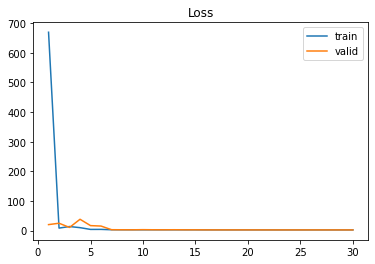

In [36]:
import matplotlib.pyplot as plt

plt.title("Loss")
plt.plot(range(1, 31), hist["train_loss"], label = "train")
plt.plot(range(1, 31), hist["val_loss"], label = "valid")
plt.legend()
plt.show()

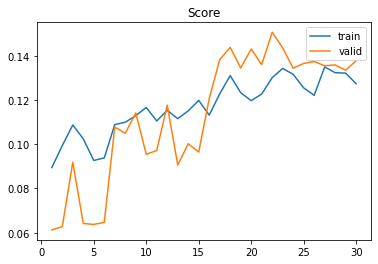

In [37]:
plt.title("Score")
plt.plot(range(1, 31), hist["train_score"], label = "train")
plt.plot(range(1, 31), hist["val_score"], label = "valid")
plt.legend()
plt.show()

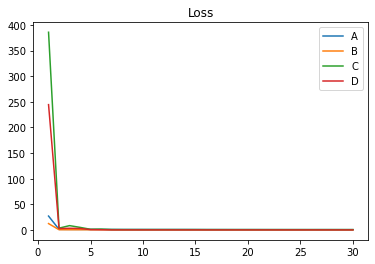

In [38]:
plt.title("Loss")
plt.plot(range(1, 31), hist_ABCD["train_loss"][0], label = "A")
plt.plot(range(1, 31), hist_ABCD["train_loss"][1], label = "B")
plt.plot(range(1, 31), hist_ABCD["train_loss"][2], label = "C")
plt.plot(range(1, 31), hist_ABCD["train_loss"][3], label = "D")
plt.legend()
plt.show()

In [39]:
submission = pd.read_csv("sample_submission.csv")
submission

,sample_id,label
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
1795,TEST_1795,0
1796,TEST_1796,0
1797,TEST_1797,0
1798,TEST_1798,0


In [40]:
submission["label"] = preds

In [41]:
submission["label"].value_counts()

0    1327
1     402
7      58
2      13
Name: label, dtype: int64

In [42]:
submission.to_csv("021901.csv", index = False)